# Bayesian estimation of open loop TAR models


In [24]:
import numpy as np
import TAR
import pandas as pd
from scipy.special import gamma, factorial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import random

In [36]:

# Generate TAR series:
y, s = TAR.tar_simulation([2,-0.9], [-2,0.5], 30, sd = 0.5, tau = 0)
dat = pd.DataFrame({"y":[i[0] for i in y], "s_1":s})
dat['x'] = dat["y"].shift(1)
dat.dropna(inplace = True)
dat.drop("s_1", axis=1, inplace = True)
# Some random partition:
dat["s_1"] = [bernoulli.rvs(0.5) for i in range(len(dat))]
orig = dat.copy()

{'Regime_1': 14, 'Regime_2': 16}


In [37]:
# dat["s_1"] = np.array(s[1:])
# # dat

In [38]:
def Proportion(dat, row, i):
    
    ## Keep the original data clean by operating on its copy rather than on itself:
    data             =       dat.copy(
    )
    n                =       len(data
    )


    ## Evaluate the constant if I=1:
    data.iloc[row,2] =      i
    n_1              =      np.sum(data.s_1)

        
    # Data Processing
    data["xs_1"]     =      data.x*data.s_1 
    data["s_2"]      =      1 - data.s_1
    data["xs_2"]     =      data["s_2"]*data["x"
    ]
    data["ys_1"]     =      data.y*data.s_1
    data["ys_2"]     =      data.y*data.s_2
    

    # Covariance Matrix of Regressors if I==1 and if I==0:
    Sxx_1             =      data.loc[:, ["s_1", "xs_1"]].T@data.loc[:, ["s_1", "xs_1"]
    ]
    Sxx_2             =      data.loc[:, ["s_2", "xs_2"]].T@data.loc[:, ["s_2", "xs_2"]
    ]
    
    # Covariance Matrix of Regressors and the Response (XY) if I==0 and I==1:
    Sxy_1            =      data.loc[:, ["s_1", "xs_1"]].T@data.ys_1
    Sxy_2            =      data.loc[:, ["s_2", "xs_2"]].T@data.ys_2
    delta_1          =      data.ys_1.T@data.ys_1 - Sxy_1.T@np.linalg.inv(Sxx_1)@Sxy_1
    delta_2          =      data.ys_2.T@data.ys_2 - Sxy_2.T@np.linalg.inv(Sxx_2)@Sxy_2
    
    Q                =      np.log(gamma((n_1 +0.01)/2                             )
    ) + np.log(gamma((n - n_1 + 0.01)/2                                       )
    ) - np.log(delta_1**((n_1 - 1 -1)/2))  - np.log(delta_2**((n - n_1 - 1 -1)/2       )
    ) - np.log(0.01 + np.linalg.det(Sxx_1.to_numpy()@Sxx_2.to_numpy(                         )
    )**0.5
    )    
    return Q

def Update(Q_1, Q_2, row, data):
    C = max(Q_1, Q_2)
    Q_1 = Q_1 - C
    Q_2 = Q_2 - C
    p = np.exp(Q_1)/(np.exp(Q_1) + np.exp(Q_2))
    data.iloc[row, 2] = bernoulli.rvs(p)
    return p, data


In [39]:
rows = [i for i in range(len(dat))]
probs = pd.DataFrame()

for j in range(1000):
    probs[f"i{j}"] = " "
    # random.shuffle(rows)
    for row in rows:
        # print(f'before:{dat.iloc[row,2]}')
        # print(f'props:{Proportion(dat, row, 1), Proportion(dat, row, 0)}')
        a = Update(Proportion(dat, row, 1), Proportion(dat, row, 0), row, dat)
        dat = a[1]
        # print(f'after: {dat.iloc[row,2]}')
        probs.loc[row, f"i{j}"] = a[0]

<ipython-input-39-568b9493f477>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{j}"] = " "
<ipython-input-39-568b9493f477>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{j}"] = " "
<ipython-input-39-568b9493f477>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{j}"] =

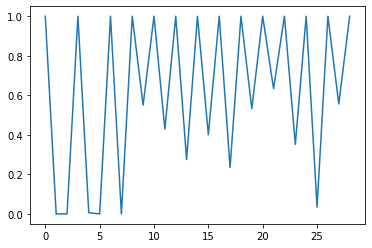

In [43]:
plt.plot(probs.iloc[:,-1])

In [45]:
probs["states"] = np.array(s[1:])
probs

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,i991,i992,i993,i994,i995,i996,i997,i998,i999,states
0,1.0,0.999988,0.999967,0.999997,0.999963,0.999962,0.999999,0.999997,0.999984,0.999984,...,0.99997,0.999988,0.999989,0.999999,0.999975,0.999945,0.999997,0.999992,0.999999,1
1,0.010951,0.000039,0.000095,0.000035,0.000032,0.000027,0.000247,0.000049,0.000045,0.000079,...,0.000007,0.000034,0.000035,0.00003,0.000018,0.000047,0.000061,0.001021,0.000013,0
2,0.000042,0.000003,0.000001,0.000016,0.000002,0.000001,0.00002,0.000012,0.000001,0.000002,...,0.000006,0.000009,0.000009,0.000011,0.000012,0.000001,0.000014,0.000271,0.000012,0
3,1.0,0.999989,0.999993,0.999995,0.999976,0.999975,0.999998,0.999995,0.999991,0.999991,...,0.999961,0.999985,0.999987,0.999998,0.999967,0.999978,0.999995,0.999985,0.999998,1
4,0.261415,0.022101,0.132049,0.02559,0.030317,0.026299,0.053668,0.032452,0.042315,0.061785,...,0.006888,0.024999,0.02464,0.006737,0.024312,0.070044,0.039404,0.010468,0.005939,0
5,0.000023,0.000001,0.0,0.000001,0.0,0.0,0.000007,0.000001,0.0,0.0,...,0.000001,0.000001,0.000001,0.000005,0.000001,0.0,0.00003,0.000001,0.000001,0
6,1.0,0.999995,0.999997,0.999997,0.999989,0.999989,0.999999,0.999998,0.999997,0.999996,...,0.999978,0.999993,0.999994,0.999999,0.999982,0.99999,0.999998,0.999992,0.999999,1
7,0.040995,0.001479,0.005537,0.00093,0.001763,0.001519,0.003696,0.001288,0.002156,0.003492,...,0.000306,0.001164,0.001158,0.000463,0.000767,0.003094,0.030595,0.000395,0.000255,0
8,0.999991,0.999859,0.999931,0.999927,0.999756,0.999742,0.999972,0.999938,0.9999,0.999905,...,0.999522,0.999839,0.99985,0.999942,0.999684,0.999801,0.999979,0.999805,0.999934,1
9,0.375705,0.324853,0.090386,0.433399,0.253979,0.260158,0.199358,0.387746,0.204771,0.188584,...,0.421599,0.394096,0.394558,0.471341,0.347119,0.157326,0.207341,0.433399,0.550628,0
